# Visualization Experiments

Lets load the data artefacts to local memory. These files are to be downloaded from S3 as the pipeline automatically uploads them to the pre-configured S3 bucket.

In [73]:
from file_util import download_files
import pickle

# Download files from S3 bucket. You can download multiple files at a time by passing a list of names
files_to_download = ["df.pkl", "mappings.pkl", 'transcript_timestamps.txt']
download_files(files_to_download)



2023-06-14 19:24:02.274 | INFO     | file_util:download_files:36 - Downloading file df.pkl
2023-06-14 19:24:04.697 | INFO     | file_util:download_files:36 - Downloading file mappings.pkl
2023-06-14 19:24:05.518 | INFO     | file_util:download_files:36 - Downloading file transcript_timestamps.txt


In [59]:
# Download spacy model for the first time
!spacy download en_core_web_md


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.2.0/en_core_web_md-3.2.0-py3-none-any.whl#egg=en_core_web_md==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 9.8 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [60]:
import spacy

spaCy_model = "en_core_web_md"
nlp = spacy.load(spaCy_model)
stopwords = nlp.Defaults.stop_words


## Example template 1

## Scatter plot of transcription with Topic modelling

Change the values of "category", "category_name" to one agenda topic and change the value of "not_category_name" and see different plots.

In [61]:
import pandas as pd
import scattertext as st


def plot_topic_modelling_and_word_to_sentence_search(df, cat_1, cat_1_name, cat_2_name):
    df = df.assign(parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences))

    corpus = st.CorpusFromParsedDocuments(
        df, category_col='ts_to_topic_mapping_top_1', parsed_col='parse'
    ).build().get_unigram_corpus().remove_terms(stopwords, ignore_absences=True).compact(st.AssociationCompactor(2000))
    
    html = st.produce_scattertext_explorer(
        corpus,
        category=cat_1, category_name=cat_1_name, not_category_name=cat_2_name,
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank
    )
    open('./demo_compact.html', 'w').write(html)

plot_topic_modelling_and_word_to_sentence_search(df,
                                                cat_1="TAM",
                                                cat_1_name="TAM",
                                                cat_2_name="Churn")

# once you are done, check the generated HTML file


## Example template 2

## Time driven Insights

In [62]:
mappings = pickle.load(open("mappings.pkl", "rb"))
timestamp_to_topic_first_match = mappings[0]
timestamp_to_topic_second_match = mappings[1]
topic_to_timestamp_first_match = mappings[2]
topic_to_timestamp_second_match = mappings[3]

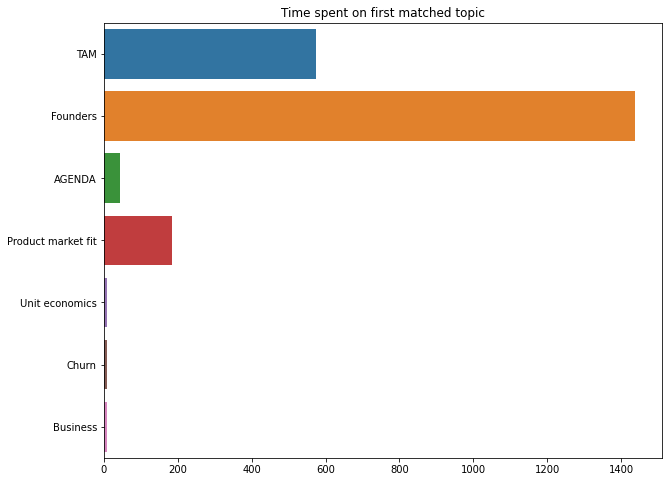

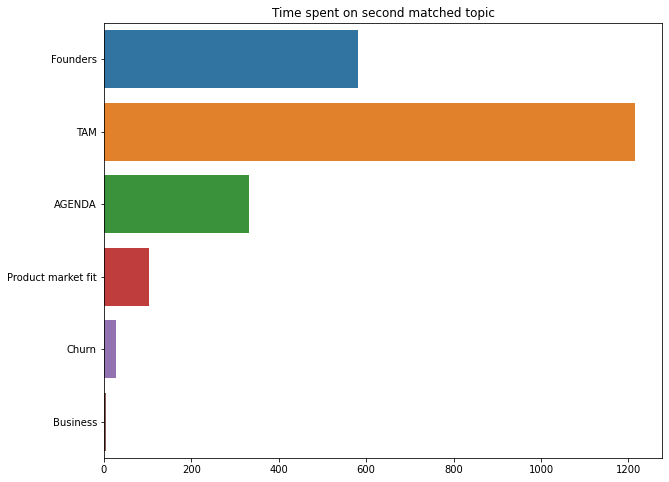

In [63]:
import collections 
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_spent_for_topic(mapping, order):
    topic_times = collections.defaultdict(int)
    for key in mapping.keys():
        duration = key[1] - key[0]
        topic_times[mapping[key]] += duration
    
    keys = list(topic_times.keys())
    vals = [int(topic_times[k]) for k in keys]    
    plt.figure(figsize=(10,8))
    sns.barplot(x=vals, y=keys).set(title='Time spent on ' + order +  ' matched topic')

        

plot_time_spent_for_topic(timestamp_to_topic_first_match, "first")
plot_time_spent_for_topic(timestamp_to_topic_second_match, "second")

## Example template 3

## Enhanced search for timelines

We can already search for a particular word in the interactive HTML document from example 1 to see a list of all transcribed sentences having an occurence of the word (in the context of the chosen topic). 

We can also retrieve all the segments(timestamps)in the transcription, related to a particular topic, to

i) Segregrate all content on a particular topic of importance.

ii) Perform selective summarization of the segregated content to make productive follow-ups. (Maybe use a model to extract action items and announcements from the transcription or selective summary ? )

iii) Use the timestamps to highlight video / audio / transcription segments.

iv) Jump to a desired segment of video / audio / transcription.

In [86]:
def retrieve_time_segments(topic):
    return topic_to_timestamp_first_match[topic]

search_topic = "Product market fit"
print("Timelines where " + search_topic + " was covered : ")
time_segments_of_interest = retrieve_time_segments(topic=search_topic)
time_segments_of_interest

Timelines where Product market fit was covered : 


[(236.0, 240.0),
 (251.12, 255.36),
 (263.44, 268.16),
 (268.16, 274.24),
 (279.2, 293.0),
 (293.0, 299.0),
 (328.84, 330.6),
 (334.2, 337.12),
 (426.24, 430.96),
 (448.16, 451.16),
 (451.16, 454.08),
 (508.0, 585.84),
 (906.0, 926.4),
 (926.4, 933.2),
 (1056.16, 1060.8),
 (1136.48, 1140.72),
 (1966.08, 1971.52),
 (2122.9, 2127.0),
 (2217.64, 2220.36),
 (2222.12, 2224.84),
 (2472.44, 2474.96)]

## Selective segregation of content

In [122]:
import json
import ast

time_segments_of_interest = retrieve_time_segments("Founders")

ts_transcript = {}
with open("transcript_timestamps.txt", "r") as f:
    ts_transcript = f.read()
ts_transcript = ast.literal_eval(ts_transcript)

selective_transcribed_content = ""
for chunk in ts_transcript["chunks"]:
    if chunk["timestamp"] in time_segments_of_interest:
        selective_transcribed_content += chunk["text"]

In [121]:
selective_transcribed_content

" companies and help them grow. And the funds that we raise will be a mix of, you know, my connections are connections and partners is going to put us in front of a lot of different investors that they know which is why I was working on the pitch stack and this more to come. So I was planning on doing this talk a bit later, but we spoke to the head of Edbett partners this week. He would prefer us to have more of a pipeline, what we can speak to investors, meeting companies that were close to pulling the all the details of the early research. But I'd like to get started at least meeting founders of these super early stage companies because that's what work focused on. And the thing is, given, you know, we have 36, 37 employees all around the world, it makes way more sense that it can be helpful. If I give everyone on the team a bit of a ground dean and just what you should be looking for, what some of the key characteristics are of a company that can scale well and become huge one day. 

## Selective topic summarization

We can use this selective content to now summarize using the already available pipeline !

# And Much More !!